# Project 15 - Image Classification (Faces)

## Project Description

<br>The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

<br>The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.
<br>Computer vision methods can be used to determine age of a person from a photo. The task then is to build and evaluate a model for verifying people's age.
<br>To start working on the task, you'll have a set of photographs of people with their ages indicated.

## Initialization

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('datasets/project_10_dataset_labels.csv')
print(labels.info())
print(f'\n')
print(labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


In [ ]:
#labels.to_csv('~/work/project_datasets/project_10_dataset.csv', index=False, header=list(labels.columns))

mean: 31.20 | median: 29.00 | mode: 30.00


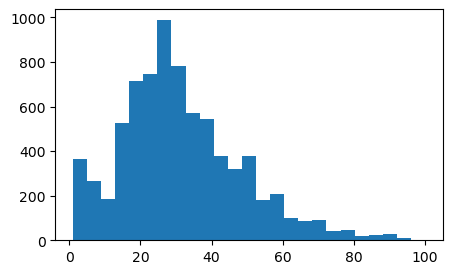

In [6]:
mean = labels['real_age'].mean()
median = labels['real_age'].median()
mode = labels['real_age'].mode()[0]
print(f'mean: {mean:.2f} | median: {median:.2f} | mode: {mode:.2f}')

plt.figure(figsize=(5,3))
plt.hist(labels['real_age'], bins=25)
plt.show()

(114, 114, 3)


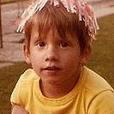

In [4]:
image_path = '/datasets/faces/final_files/000000.jpg'
img = Image.open(image_path)
print(np.array(img).shape)
img

In [5]:
path = '/datasets/faces/final_files'
def data_walkthrough(dir_path):
    for dirpath, dirnames, files in os.walk(dir_path):
        print(dirpath, dirnames, len(files))
        
data_walkthrough(path)

/datasets/faces/final_files [] 7591


In [6]:
datagen=ImageDataGenerator(validation_split=0.25, rescale=1.0/255)
path = '/datasets/faces/'

train_datagen_flow = datagen.flow_from_directory(path,
                                                 target_size=(256, 256),
                                                 batch_size=16,
                                                 shuffle=False,
                                                 class_mode='sparse',
                                                 subset='training')

val_datagen_flow = datagen.flow_from_directory(path,
                                               target_size=(256, 256),
                                               batch_size=16,
                                               shuffle=False,
                                               class_mode='sparse',
                                               subset='validation')

Found 5694 images belonging to 1 classes.
Found 1897 images belonging to 1 classes.


## EDA

In [7]:
features, target = next(train_datagen_flow)
features[0].shape

(256, 256, 3)

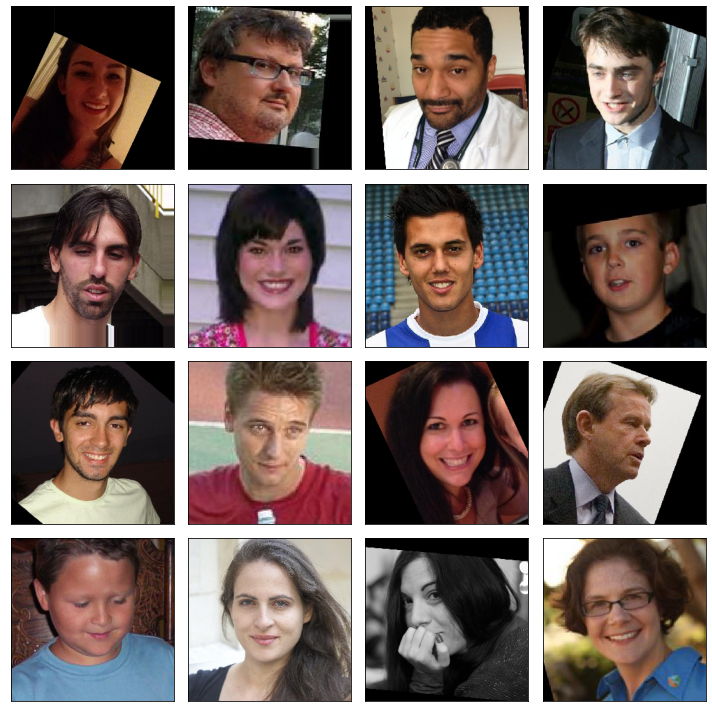

In [8]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Findings

1. There are 7591 images in the final_files folder, along with 7591 labels in the 'labels.csv'
2. All of the images are of different sizes and have been resized in the ImageDataGenerator function
3. The age distribution resembles a right skewed normal distribution, with a mode of 30 and mean of 31.20




## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.
<br>To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.
<br>The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [10]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [11]:
def load_train(path):
    """
    It loads the train part of dataset from path
    """
    
    label_path='/datasets/faces/labels.csv'
    labels = pd.read_csv(label_path)
    
    datagen=ImageDataGenerator(validation_split=0.25, rescale=1.0/255)
    train_gen_flow=datagen.flow_from_dataframe(dataframe=labels,                         
                                            directory=path,               
                                            x_col=labels.columns[0],        
                                            y_col=labels.columns[1],                 
                                            target_size=(256, 256),   
                                            batch_size=16,                    
                                            class_mode=None,                  
                                            subset='training',
                                            shuffle=True,
                                            seed=42
                                            )
    return train_gen_flow

In [12]:
def load_test(path):
    """
    It loads the validation/test part of dataset from path
    """
    
    label_path='/datasets/faces/labels.csv'
    labels = pd.read_csv(label_path)
    
    datagen=ImageDataGenerator(validation_split=0.25, rescale=1.0/255)
    test_gen_flow=datagen.flow_from_dataframe(dataframe=labels,                         
                                          directory=path,               
                                          x_col=labels.columns[0],        
                                          y_col=labels.columns[1],                 
                                          target_size=(256, 256),   
                                          batch_size=16,                    
                                          class_mode=None,                  
                                          subset='validation',
                                          shuffle=True,
                                          seed=42
                                          )
    return test_gen_flow

In [13]:
def create_model(input_shape):
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    optimizer = Adam(learning_rate=0.001)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [14]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              epochs=epochs,
              validation_data=test_data,
              batch_size=batch_size
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [15]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect
with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

## Conclusions

1. The model underwent a total of 20 epochs of training, with each epoch completing in 35 seconds on a GPU platform, indicating efficient processing.
2. Although the train_loss steadily decreased throughout the epochs, the val_loss began to plateau and even increase after the 10th epoch. This divergence suggests that the model started to overfit the training data.
3. To address this overfitting, it's advisable to either reduce the number of epochs during training or implement early stopping techniques to prevent the model from memorizing the training data.
4. The primary objective of this project is to develop a model capable of accurately verifying individuals' ages to prevent the sale of alcohol to minors. However, based on the observed train_mae and val_mae, it appears that the model's accuracy may not be sufficient to reliably achieve this goal.
5. Given the limitations in accuracy, it may be necessary to train an different model capable of achieving a lower MAE to mitigate the risk of unintentionally selling alcohol to minors.
6. Alternatively, a classification model could be developed to categorize individuals into three age groups: [<10], [10-30], and [>30]. In cases where a customer falls into the middle category, their age could be verified by a human evaluator using their ID card.  
7. Conversely, a revised project objective could focus on implementing a model for scanning and detecting the date of birth on individuals' ID cards as a means of accurately determining their age. This approach could provide a more reliable means of age verification, potentially enhancing the effectiveness of the model in real-world scenarios.

# Checklist

- [x]  The code is error free
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented
- [x]  The model's MAE score is not higher than 8
- [x]  The findings provided based on the results of the model training